# JOVIAL, the ChiVO Cloud Service
## SOCHIAS 2017
### Amelia Bayo, Mauricio Araya and Mauricio Solar
This notebook presents a simple example of what can be done with JOVIAL
### Initialiization (imports)

In [1]:
import os
import urllib.request
import tarfile
from shutil import copyfile
import sys
sys.path.append('../ACALIB')
from astropy.io import fits
import matplotlib.pyplot as plt
import acalib as aca
import numpy as np

## 1.- Downloading and Decompressing ALMA (SV) Data

In [2]:
global DOWNLOADS_DIR 
DOWNLOADS_DIR= '.'
# Data from ALMA science verification 

# URLs of the tarballs
twhydra_url  = 'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz'
m100_url     = 'https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz'
iras_url     = 'https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz'

# Fits names and their "fantasy" names 
twhydra_file = 'TWHydra_CO3_2line.image.fits'
m100_file    = 'M100line.image.fits'
iras_file    = 'I16293_220GHzcorrected.ms.selfcube.image.fits'

Function to retrieve the tarball and the fits file.

In [3]:
def download_extract_and_move(url,ffile):
    # Obtain the filename
    name = url.rsplit('/', 1)[-1]
    filename = os.path.join(DOWNLOADS_DIR, name)
    # Download the file if not found
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)
    # Decompress (if needed) and copy the selected file to the DOWNLOADS_DIR
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    if not os.path.isdir(sdir):
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()
    copyfile(sdir+"/"+ffile, DOWNLOADS_DIR+"/"+ffile)

## 2.- Loading and a Quick Look at the Data

In [4]:
# Extract File
download_extract_and_move(twhydra_url,twhydra_file)
# Load File
hdulist = fits.open(DOWNLOADS_DIR+'/'+twhydra_file)
twhydra_cube    = aca.HDU_to_NDData(hdulist[0])

INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]


### Show the header

In [5]:
twhydra_cube.meta

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  118                                                  
NAXIS4  =                    1                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   4.668472210566E-04                                                  
BMIN    =   4.255372948117E-04                                                  
BPA     =   2.230152130127E+01                                                  
BTYPE   = 'Intensity'       

### Quick Look
You can take a quick look to the data by computing the zeroth moment:
$$ M_0 = \sum_i I_i $$
and its integrated spectra.

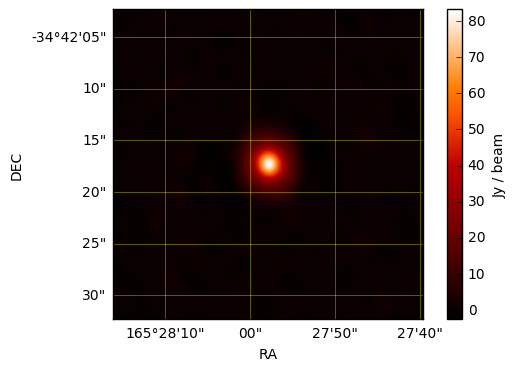

In [6]:
twhydra_m0 = aca.moment0(twhydra_cube)
aca.visualize(twhydra_m0)
plt.show()

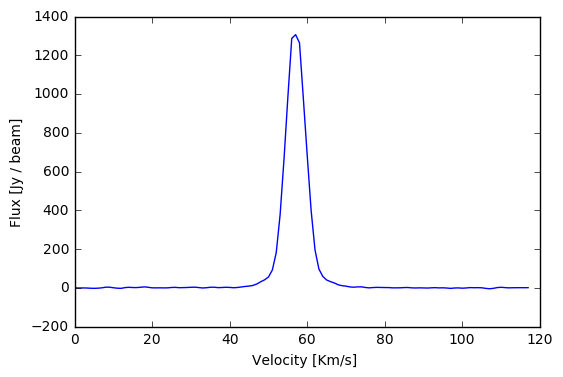

In [9]:
def show_spectra(cube):
    spec = aca.spectra(cube)
    vels = aca.spectral_velocities(cube)
    plt.plot(spec)
    plt.ylabel('Flux ['+str(cube.unit)+']')
    plt.xlabel('Velocity [Km/s] ')

    
    
show_spectra(twhydra_cube)
plt.show()

## Interactivity

In [10]:
from ipywidgets import interact

def interactive_denoising(threshold=0.0):
    dencube=aca.denoise(twhydra_cube,threshold=threshold)
    show_spectra(dencube)
    plt.show()

mmax = twhydra_cube.data.max()
mmin = twhydra_cube.data.min()
print(mmax,mmin)
interact(interactive_denoising,threshold=(mmin,mmax))

AttributeError: 'float' object has no attribute 'value'

<function __main__.interactive_denoising>

In [ ]:
ra_max   = twhydra_cube.meta['NAXIS1']
dec_max  = twhydra_cube.meta['NAXIS2']
spec_max = twhydra_cube.meta['NAXIS3']

def cut_and_show(rlow=0,rhigh=ra_max,
                 dlow=0,dhigh=dec_max,
                 slow=0,shigh=spec_max,
                 threshold=0.0):
    # Cut the cube
    lower       = [slow,dlow,rlow]
    upper       = [shigh,dhigh,rhigh]
    tcube       = aca.cut(twhydra_cube,lower=lower,upper=upper)
    tcube       = aca.denoise(tcube,threshold=threshold)
    # Diplay
    plt.figure()
    plt.subplot(2,3,1)
    plt.imshow(tcube.data.sum(axis=(0)),origin='lower')
    plt.subplot(2,3,2)
    plt.imshow(tcube.data.sum(axis=(1)),origin='lower')
    plt.subplot(2,3,3)
    plt.imshow(tcube.data.sum(axis=(2)),origin='lower')
    plt.subplot(2,1,2)
    show_spectra(tcube)
    plt.show()

res=interact(cut_and_show,
             rlow=(0,ra_max), rhigh=(0,ra_max),
             dlow=(0,dec_max),dhigh=(0,dec_max),
             slow=(0,spec_max),shigh=(0,spec_max),
             threshold=(mmin,mmax))

In [ ]:
limits = res.widget.kwargs
limits

In [ ]:
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
twhydra_crop = aca.cut(twhydra_cube,lower=lower,upper=upper)
print("MOMENT 0")
aca.visualize(aca.moment0(twhydra_crop),contour=True)
plt.show()
print("MOMENT 1")
(stcrop,a,b) = aca.standarize(twhydra_crop)
aca.visualize(aca.moment1(stcrop),contour=True)
plt.show()

## 3.- Analysis
First let us standarize the data

In [ ]:
(twhydra_cube,a,b) = aca.standarize(twhydra_cube)
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
twhydra_crop = aca.cut(twhydra_cube,lower=lower,upper=upper)
mmax = twhydra_cube.data.max()
mmin = twhydra_cube.data.min()
(a,b)

In [ ]:
res_noise=interact(cut_and_show,
             rlow=(0,ra_max), rhigh=(0,ra_max),
             dlow=(0,dec_max),dhigh=(0,dec_max),
             slow=(0,spec_max),shigh=(0,spec_max), 
             threshold=(mmin,mmax))

In [ ]:
limits = res_noise.widget.kwargs
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
noise_crop = aca.cut(twhydra_cube,lower=lower,upper=upper)
myrms=aca.rms(noise_crop.data)
myrms

## Obtain the PHR!

In [ ]:
(rep,syn,res)=aca.core.scatpix_detect(twhydra_crop.data,threshold=3.0*myrms,noise=myrms,full_output=True)
print(len(rep))
print(res.size)

In [ ]:
plt.figure()
syn2D=syn.sum(axis=(0))
vm=syn2D.max()
plt.subplot(121)
plt.imshow(syn2D,vmin=0,vmax=vm,origin='lower')
plt.subplot(122)
plt.imshow(res.sum(axis=(0)),vmin=0,vmax=vm,origin='lower')
plt.colorbar()
plt.show()

In [ ]:
from sompy.sompy import SOMFactory
newRep=rep['center'].data
sm = SOMFactory().build(newRep, normalization = 'var', initialization='pca')
sm.train(n_job=1, verbose=False, train_rough_len=30, train_finetune_len=30)

In [ ]:
sm.codebook.matrix

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
def show_manifold(sm):
    cbook=sm.codebook.matrix
    fig=plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cbook[:,0],cbook[:,1], cbook[:,2],c=cbook[:,0])#, c=c, marker=m)
    for cb,dm_elm in zip(cbook,sm._distance_matrix):
        conn=(dm_elm==1).nonzero()
        for idx in conn[0]:
            ot=cbook[idx]
            ax.plot([cb[0],ot[0]],[cb[1],ot[1]],[cb[2],ot[2]],color = 'Grey',alpha=0.5)
    plt.show()
show_manifold(sm)

## 4.- M100

In [ ]:
%matplotlib inline
# Extract File
download_extract_and_move(m100_url,m100_file)
# Load Fileinline
hdulist = fits.open(DOWNLOADS_DIR+'/'+m100_file)
m100_cube    = aca.HDU_to_NDData(hdulist[0])

In [ ]:
m100_cube.meta

In [ ]:
(ext1,ext2)=aca.extent(m100_cube)
ext1

In [ ]:
ext2

In [ ]:
cent=aca.center(m100_cube)
cent

In [ ]:
max_radius=(ext1[2]-cent[2])
max_radius.value

In [ ]:
%matplotlib inline
import aplpy
from astropy import units as u
from matplotlib.patches import Circle, Rectangle
(m100_cube,a,b) = aca.standarize(m100_cube)
m100_m0 = aca.moment0(m100_cube)


def select_radius(radius=max_radius.value):
    ax=plt.subplot(111,projection=m100_m0.wcs)
    ax.imshow(m100_m0.data,origin='lower',cmap='Greys')
    cc = Circle((cent[2].value,cent[1].value), radius=radius, edgecolor='green', facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(cc)

mycirc=interact(select_radius,radius=(0.0,max_radius.value,max_radius.value/1000))

In [ ]:
rad=mycirc.widget.kwargs['radius']
rad=(rad*u.deg).to('arcsec')
rad

In [ ]:
from astroquery import *
from astropy import coordinates
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs(keywords=['allWISE'])
for key,item in catalog_list.items():
    print(key+" : "+item.description)

In [ ]:
pos=coordinates.SkyCoord(cent[2],cent[1])
#print (fov*u.deg).to('arcsec')
#print cen*u.deg
tablist=Vizier.query_region(coordinates=pos,radius=rad)

In [ ]:
tablist

In [ ]:
atable=tablist['I/337/gaia']
atable

In [ ]:
fig = aplpy.FITSFigure(aca.NDData_to_HDU(m100_m0))
fig.show_grayscale()
fig.show_markers(atable['_RAJ2000'],atable['_DEJ2000'])

In [ ]:
%matplotlib inline
mside=(ext1[2] - ext2[2]).value
oside=(ext2[1] - ext1[1]).value



def select_noise(rside=mside/10.0,dside=oside/10.0,ra=cent[2].value,dec=cent[1].value,vini=ext1[0].value,vfin=ext2[0].value):
    ax=plt.subplot(121,projection=m100_m0.wcs)
    ax.imshow(m100_m0.data,origin='lower',cmap='Greys')
    cc = Rectangle((ra-rside,dec-dside),2*rside,2*dside,edgecolor='green', facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(cc)
    ax2=plt.subplot(122)
    ld=np.rint(m100_cube.wcs.wcs_world2pix([[ra-rside,dec-dside,vini]],0))
    lu=np.rint(m100_cube.wcs.wcs_world2pix([[ra+rside,dec+dside,vfin]],0))
    lower=np.array([ld,lu]).min(axis=0)[0]
    upper=np.array([ld,lu]).max(axis=0)[0]
    newcube=aca.cut(m100_cube,lower=lower[::-1],upper=upper[::-1])
    show_spectra(newcube)
    plt.show()


myrect=interact(select_noise,
                rside=(0.0,mside,mside/1000.0),
                dside=(0.0,oside,oside/1000.0),
                ra=(ext2[2].value,ext1[2].value,mside/1000.0),
                dec=(ext1[1].value,ext2[1].value,oside/1000.0),
                vini=(ext1[0].value,ext2[0].value),
                vfin=(ext1[0].value,ext2[0].value))

In [ ]:
print(oside)
